In [1]:
import kagglehub
import pickle
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Path to dataset files:", path)

OUTPUT_DIR = "./exports/delayed_delivery"
image_path = os.path.join(OUTPUT_DIR, "visualizations")
metrics_path = os.path.join(OUTPUT_DIR, "metrics")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(image_path, exist_ok=True)
os.makedirs(metrics_path, exist_ok=True)

customers          = pd.read_csv(os.path.join(path, 'olist_customers_dataset.csv'))
items              = pd.read_csv(os.path.join(path, 'olist_order_items_dataset.csv'))
payments           = pd.read_csv(os.path.join(path, 'olist_order_payments_dataset.csv'))
reviews            = pd.read_csv(os.path.join(path, 'olist_order_reviews_dataset.csv'))
orders             = pd.read_csv(os.path.join(path, 'olist_orders_dataset.csv'))
products           = pd.read_csv(os.path.join(path, 'olist_products_dataset.csv'))
sellers            = pd.read_csv(os.path.join(path, 'olist_sellers_dataset.csv'))
category_translation = pd.read_csv(os.path.join(path, 'product_category_name_translation.csv'))
geolocation        = pd.read_csv(os.path.join(path, 'olist_geolocation_dataset.csv'))


Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Path to dataset files: /kaggle/input/brazilian-ecommerce


In [2]:

df = pd.merge(orders, reviews, on='order_id')

date_columns = [
    'order_purchase_timestamp', 'order_approved_at',
    'order_delivered_carrier_date', 'order_delivered_customer_date',
    'order_estimated_delivery_date', 'review_creation_date',
    'review_answer_timestamp'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

delivered_orders = df[df['order_status'] == 'delivered'].copy()

delivered_orders['actual_delivery_days'] = (
    delivered_orders['order_delivered_customer_date'] -
    delivered_orders['order_purchase_timestamp']
).dt.days

delivered_orders['estimated_delivery_days'] = (
    delivered_orders['order_estimated_delivery_date'] -
    delivered_orders['order_purchase_timestamp']
).dt.days

delivered_orders['delivery_delay_days'] = (
    delivered_orders['actual_delivery_days'] -
    delivered_orders['estimated_delivery_days']
)

print("\n=== Delivery Delay Statistics ===")
print(f"Average delay : {delivered_orders['delivery_delay_days'].mean():.2f} days")
print(f"Median delay  : {delivered_orders['delivery_delay_days'].median():.2f} days")
print(f"Min delay     : {delivered_orders['delivery_delay_days'].min():.2f} days")
print(f"Max delay     : {delivered_orders['delivery_delay_days'].max():.2f} days")

late_mask = delivered_orders['delivery_delay_days'] > 0
print(f"\nOrders that were late : {late_mask.sum()} ({late_mask.mean()*100:.1f}%)")
print(f"Avg delay for late orders  : {delivered_orders.loc[late_mask, 'delivery_delay_days'].mean():.2f} days")
print(f"Avg review (late orders)   : {delivered_orders.loc[late_mask, 'review_score'].mean():.2f}")
print(f"Avg review (on-time/early) : {delivered_orders.loc[~late_mask, 'review_score'].mean():.2f}")



=== Delivery Delay Statistics ===
Average delay : -11.32 days
Median delay  : -12.00 days
Min delay     : -146.00 days
Max delay     : 189.00 days

Orders that were late : 7183 (7.5%)
Avg delay for late orders  : 10.02 days
Avg review (late orders)   : 2.46
Avg review (on-time/early) : 4.29


In [3]:
delivered_orders_with_loc = pd.merge(
    delivered_orders,
    customers[['customer_id', 'customer_zip_code_prefix',
               'customer_city', 'customer_state', 'customer_unique_id']],
    on='customer_id', how='left'
)

order_sellers = items.groupby('order_id')['seller_id'].first().reset_index()
order_sellers = pd.merge(
    order_sellers,
    sellers[['seller_id', 'seller_state', 'seller_zip_code_prefix', 'seller_city']],
    on='seller_id', how='left'
)

delivered_orders_with_loc = pd.merge(
    delivered_orders_with_loc,
    order_sellers[['order_id', 'seller_state', 'seller_zip_code_prefix', 'seller_city']],
    on='order_id', how='left'
)

delivered_orders_with_loc['order_size'] = delivered_orders_with_loc['order_id'].map(
    items.groupby('order_id')['order_item_id'].count()
)
print(f"\nAdded order_size  |  range: {delivered_orders_with_loc['order_size'].min()} - {delivered_orders_with_loc['order_size'].max()} items")


Added order_size  |  range: 1 - 21 items


In [4]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return R * 2 * np.arcsin(np.sqrt(a))

zip_coords = (
    geolocation
    .groupby('geolocation_zip_code_prefix')[['geolocation_lat', 'geolocation_lng']]
    .mean()
)

In [5]:
delivered_orders_with_loc['customer_lat'] = delivered_orders_with_loc['customer_zip_code_prefix'].map(zip_coords['geolocation_lat'])
delivered_orders_with_loc['customer_lng'] = delivered_orders_with_loc['customer_zip_code_prefix'].map(zip_coords['geolocation_lng'])

delivered_orders_with_loc['seller_lat'] = delivered_orders_with_loc['seller_zip_code_prefix'].map(zip_coords['geolocation_lat'])
delivered_orders_with_loc['seller_lng'] = delivered_orders_with_loc['seller_zip_code_prefix'].map(zip_coords['geolocation_lng'])

delivered_orders_with_loc['customer_seller_distance_km'] = haversine_km(
    delivered_orders_with_loc['customer_lat'],
    delivered_orders_with_loc['customer_lng'],
    delivered_orders_with_loc['seller_lat'],
    delivered_orders_with_loc['seller_lng']
)

median_dist = delivered_orders_with_loc['customer_seller_distance_km'].median()
delivered_orders_with_loc['customer_seller_distance_km'] = (
    delivered_orders_with_loc['customer_seller_distance_km'].fillna(median_dist)
)

print(f"\nAdded haversine distance feature")
print(f"   Distance range : {delivered_orders_with_loc['customer_seller_distance_km'].min():.0f} - {delivered_orders_with_loc['customer_seller_distance_km'].max():.0f} km")
print(f"   Mean distance  : {delivered_orders_with_loc['customer_seller_distance_km'].mean():.0f} km")


Added haversine distance feature
   Distance range : 0 - 8678 km
   Mean distance  : 599 km


In [6]:

features_at_order_time = [
    'order_purchase_timestamp',
    'customer_state', 'customer_city', 'customer_zip_code_prefix',
    'seller_state',   'seller_city',   'seller_zip_code_prefix',
    'order_size',
    'customer_seller_distance_km'
]

model_df = delivered_orders_with_loc[
    features_at_order_time + ['delivery_delay_days']
].copy()

model_df['purchase_month']       = pd.to_datetime(model_df['order_purchase_timestamp']).dt.month
model_df['purchase_day_of_week'] = pd.to_datetime(model_df['order_purchase_timestamp']).dt.dayofweek
model_df['purchase_hour']        = pd.to_datetime(model_df['order_purchase_timestamp']).dt.hour
model_df['is_weekend']           = (model_df['purchase_day_of_week'] >= 5).astype(int)
model_df['purchase_quarter']     = pd.to_datetime(model_df['order_purchase_timestamp']).dt.quarter
model_df = model_df.drop('order_purchase_timestamp', axis=1)

model_df['state_pair'] = model_df['customer_state'] + '_TO_' + model_df['seller_state']

state_to_region = {
    'AC': 'North',        'AM': 'North',        'AP': 'North',    'PA': 'North',
    'RO': 'North',        'RR': 'North',        'TO': 'North',
    'AL': 'Northeast',    'BA': 'Northeast',    'CE': 'Northeast', 'MA': 'Northeast',
    'PB': 'Northeast',    'PE': 'Northeast',    'PI': 'Northeast', 'RN': 'Northeast',
    'SE': 'Northeast',
    'DF': 'Central-West', 'GO': 'Central-West', 'MT': 'Central-West', 'MS': 'Central-West',
    'ES': 'Southeast',    'MG': 'Southeast',    'RJ': 'Southeast', 'SP': 'Southeast',
    'PR': 'South',        'RS': 'South',        'SC': 'South'
}

model_df['customer_region'] = model_df['customer_state'].map(state_to_region)
model_df['seller_region']   = model_df['seller_state'].map(state_to_region)
model_df['region_pair']     = model_df['customer_region'] + '_TO_' + model_df['seller_region']

In [7]:
from sklearn.preprocessing import LabelEncoder

clean_df = model_df.copy()

categorical_cols = ['customer_state', 'seller_state', 'state_pair',
                    'customer_region', 'seller_region', 'region_pair']

overall_mean_delay = delivered_orders_with_loc['delivery_delay_days'].mean()

city_mean_delay = delivered_orders_with_loc.groupby('customer_city')['delivery_delay_days'].mean().to_dict()
clean_df['customer_city_avg_delay'] = clean_df['customer_city'].map(city_mean_delay).fillna(overall_mean_delay)

zip_mean_delay = delivered_orders_with_loc.groupby('customer_zip_code_prefix')['delivery_delay_days'].mean().to_dict()
zip_order_count = delivered_orders_with_loc.groupby('customer_zip_code_prefix').size().to_dict()
clean_df['customer_zip_avg_delay']    = clean_df['customer_zip_code_prefix'].map(zip_mean_delay).fillna(overall_mean_delay)
clean_df['customer_zip_order_volume'] = clean_df['customer_zip_code_prefix'].map(zip_order_count).fillna(0)

seller_zip_mean_delay = delivered_orders_with_loc.groupby('seller_zip_code_prefix')['delivery_delay_days'].mean().to_dict()
clean_df['seller_zip_avg_delay'] = clean_df['seller_zip_code_prefix'].map(seller_zip_mean_delay).fillna(overall_mean_delay)

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    clean_df[col + '_encoded'] = le.fit_transform(clean_df[col].astype(str))
    label_encoders[col] = le

clean_df = clean_df.drop(
    columns=categorical_cols + [
        'customer_city', 'seller_city',
        'customer_zip_code_prefix', 'seller_zip_code_prefix'
    ]
)

print("\n=== FINAL FEATURES FOR MODELING ===")
print(clean_df.columns.tolist())
print(f"\nShape: {clean_df.shape}")

print("\n=== MISSING VALUES ===")
print(clean_df.isnull().sum())
clean_df = clean_df.dropna()


=== FINAL FEATURES FOR MODELING ===
['order_size', 'customer_seller_distance_km', 'delivery_delay_days', 'purchase_month', 'purchase_day_of_week', 'purchase_hour', 'is_weekend', 'purchase_quarter', 'customer_city_avg_delay', 'customer_zip_avg_delay', 'customer_zip_order_volume', 'seller_zip_avg_delay', 'customer_state_encoded', 'seller_state_encoded', 'state_pair_encoded', 'customer_region_encoded', 'seller_region_encoded', 'region_pair_encoded']

Shape: (96361, 18)

=== MISSING VALUES ===
order_size                     0
customer_seller_distance_km    0
delivery_delay_days            8
purchase_month                 0
purchase_day_of_week           0
purchase_hour                  0
is_weekend                     0
purchase_quarter               0
customer_city_avg_delay        0
customer_zip_avg_delay         0
customer_zip_order_volume      0
seller_zip_avg_delay           0
customer_state_encoded         0
seller_state_encoded           0
state_pair_encoded             0
customer_

In [8]:


feature_cols = [col for col in clean_df.columns if col != 'delivery_delay_days']
X = clean_df[feature_cols]
y = clean_df['delivery_delay_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n=== DATA SPLIT ===")
print(f"Training set : {X_train.shape}")
print(f"Test set     : {X_test.shape}")

numerical_cols = [
    'purchase_month', 'purchase_day_of_week', 'purchase_hour',
    'purchase_quarter', 'customer_zip_order_volume',
    'customer_city_avg_delay', 'customer_zip_avg_delay', 'seller_zip_avg_delay',
    'customer_seller_distance_km'
]

scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]  = scaler.transform(X_test[numerical_cols])

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print("\n=== REGRESSION MODEL PERFORMANCE ===")
print(f"Mean Absolute Error (MAE) : {mae:.2f} days")
print(f"Root Mean Squared Error   : {rmse:.2f} days")
print(f"R² Score                  : {r2:.4f}")
print(f"\nInterpretation: On average, our predictions are off by {mae:.2f} days.")




=== DATA SPLIT ===
Training set : (77082, 17)
Test set     : (19271, 17)

=== REGRESSION MODEL PERFORMANCE ===
Mean Absolute Error (MAE) : 5.57 days
Root Mean Squared Error   : 8.43 days
R² Score                  : 0.3102

Interpretation: On average, our predictions are off by 5.57 days.


In [9]:
metrics_path1 = os.path.join(OUTPUT_DIR+'/metrics', 'metrics.txt')
with open(metrics_path1, 'w') as f:
    f.write("=== REGRESSION MODEL PERFORMANCE ===\n")
    f.write(f"Mean Absolute Error (MAE) : {mae:.2f} days\n")
    f.write(f"Root Mean Squared Error   : {rmse:.2f} days\n")
    f.write(f"R2 Score                  : {r2:.4f}\n")
    f.write(f"\nInterpretation: On average, predictions are off by {mae:.2f} days.\n")
print(f"Metrics saved: {metrics_path}")

predictions_df = X_test.copy()
predictions_df['actual_delay_days']    = y_test.values
predictions_df['predicted_delay_days'] = y_pred
predictions_df['residual']             = y_test.values - y_pred
predictions_path = os.path.join(metrics_path, 'predictions.csv')
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved: {predictions_path}")


Metrics saved: ./exports/delayed_delivery/metrics
Predictions saved: ./exports/delayed_delivery/metrics/predictions.csv


In [10]:
os.listdir(OUTPUT_DIR)

['visualizations', 'metrics.txt', 'metrics']

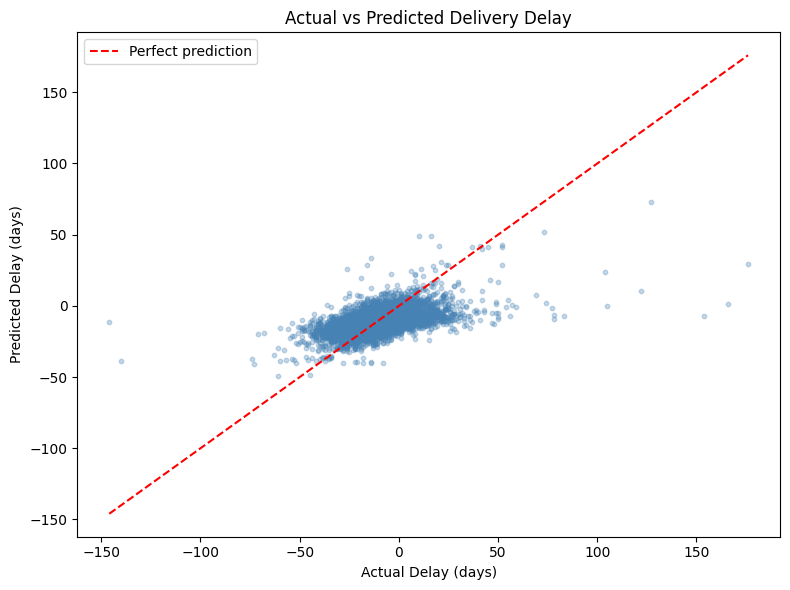

Plot saved: ./exports/delayed_delivery/visualizations/actual_vs_predicted.png


In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=1.5, label='Perfect prediction')
plt.xlabel('Actual Delay (days)')
plt.ylabel('Predicted Delay (days)')
plt.title('Actual vs Predicted Delivery Delay')
plt.legend()
plt.tight_layout()
plot1_path = os.path.join(image_path, 'actual_vs_predicted.png')
plt.savefig(plot1_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Plot saved: {plot1_path}")



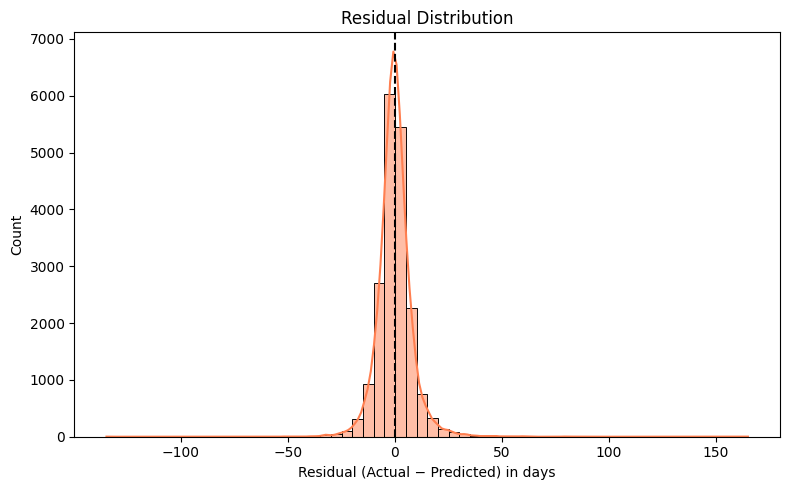

Plot saved: ./exports/delayed_delivery/visualizations/residual_distribution.png


In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=60, kde=True, color='coral')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Residual (Actual − Predicted) in days')
plt.title('Residual Distribution')
plt.tight_layout()
plot2_path = os.path.join(image_path, 'residual_distribution.png')
plt.savefig(plot2_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Plot saved: {plot2_path}")



/tmp/ipython-input-4105537844.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


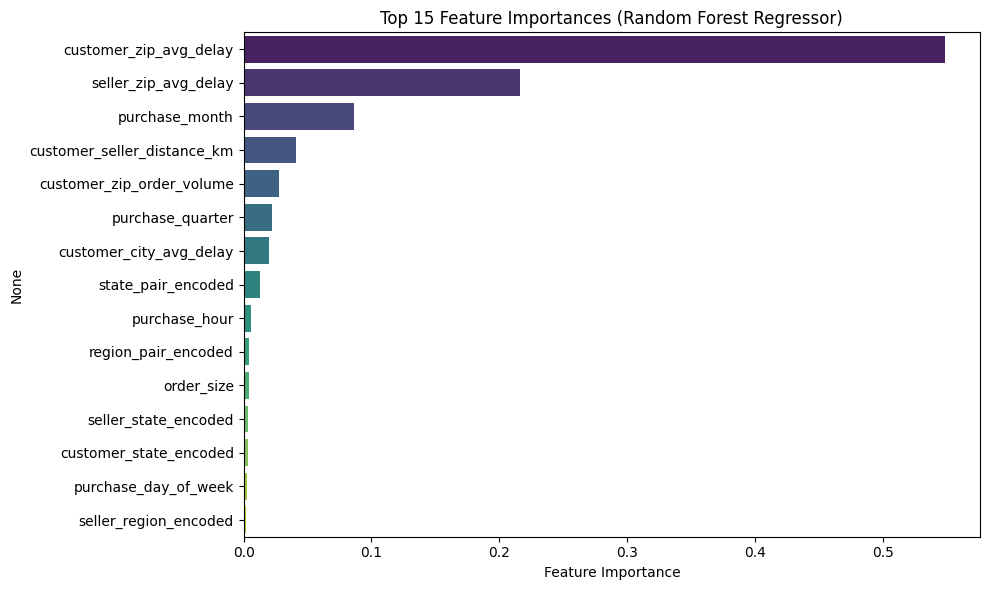

Plot saved: ./exports/delayed_delivery/visualizations/feature_importance.png


In [13]:
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_cols)
top_features = feature_importance.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances (Random Forest Regressor)')
plt.tight_layout()
plot3_path = os.path.join(image_path, 'feature_importance.png')
plt.savefig(plot3_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"Plot saved: {plot3_path}")



In [14]:
print("\n=== TOP FEATURES ===")
print(top_features)

top_features.to_csv(os.path.join(metrics_path, 'feature_importance.csv'), header=['importance'])

model_path = os.path.join(metrics_path, 'rf_regressor.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Model saved: {model_path}")

scaler_path = os.path.join(metrics_path, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Scaler saved: {scaler_path}")

print(f"All results saved to: {metrics_path}")


=== TOP FEATURES ===
customer_zip_avg_delay         0.548695
seller_zip_avg_delay           0.215885
purchase_month                 0.086175
customer_seller_distance_km    0.041263
customer_zip_order_volume      0.027455
purchase_quarter               0.022042
customer_city_avg_delay        0.020189
state_pair_encoded             0.012850
purchase_hour                  0.005722
region_pair_encoded            0.004175
order_size                     0.004054
seller_state_encoded           0.003437
customer_state_encoded         0.003079
purchase_day_of_week           0.002495
seller_region_encoded          0.001493
dtype: float64
Model saved: ./exports/delayed_delivery/metrics/rf_regressor.pkl
Scaler saved: ./exports/delayed_delivery/metrics/scaler.pkl
All results saved to: ./exports/delayed_delivery/metrics
